In [36]:
import os
import pandas as pd
import numpy as np

import itertools
import operator
import string
from collections import defaultdict, Counter

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

# Plotly Setup

In [46]:
# plotly username and password
with open('../_credentials/plotly.txt', 'r') as infile:
    user, pw = infile.read().strip().split(', ')
    
plotly.tools.set_credentials_file(username=user, api_key=pw)

text_color = 'rgb(107, 107, 107)'

colors_dict = {'grey':'rgb(189, 195, 199)', 'aqua':'rgb( 54, 215, 183)', 'navy':'rgb( 31,  58, 147)',
            'purple':'rgb(142,  68, 173)', 'blue':'rgb( 25, 181, 254)', 'green':'rgb( 46, 204, 113)',
            'yellow':'rgb(253, 231,  76)', 'orange':'rgb(250, 121,  33)', 'red':'rgb(242,  38,  19)'}

colors_lst = [colors_dict['yellow'], colors_dict['orange'], colors_dict['red'], 
              colors_dict['green'], colors_dict['blue'], colors_dict['purple'], 
              colors_dict['navy'], colors_dict['aqua'], colors_dict['grey']]

# Load Cleaned Data

In [47]:
from src.my_aws import S3

KEY_OMDB_TOR = 'OMDB_Torrents.csv'
KEY_NUM = 'TheNumbers_budgets.csv'
KEY_FINAL = 'Final_Data.csv'
BUCKET = 'movie-torrents'

s3_obj = S3()
df = s3_obj.get_data(KEY_FINAL, BUCKET)

# update dates to datetime objects
df['Released'] = pd.to_datetime(df['Released'])
df['Year'] = pd.to_numeric(pd.DatetimeIndex(df['Released']).year)
df['Month'] = pd.to_numeric(pd.DatetimeIndex(df['Released']).month)

# Number of Films Released Annually

In [48]:
# number of titles per year in dataset
df_yr = df['Year'].value_counts().reset_index()
df_yr.columns = ['Year','Count']

yr_start = df['Year'].min(axis=0)
yr_stop = df['Year'].max(axis=0)
trace = go.Bar(x=df_yr['Year'], y=df_yr['Count'], marker=dict(color=colors_dict['red']))

In [49]:
data = [trace]
layout = go.Layout(
    title='Movies Released Annually ({0}-{1})'.format(yr_start, yr_stop),
    xaxis=dict(
        title='Release Year',
        tickfont=dict(size=14, color=text_color)),
    yaxis=dict(
        title='Number of Movies',
        titlefont=dict(size=16, color=text_color),
        tickfont=dict(size=14, color=text_color)),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='style-bar')

# Trim Dataset by Years of Interest

In [50]:
def df_year_limit(start, stop, df):
    mask = (df['Year'] >= start) & (df['Year'] <= stop)
    df = df.loc[mask]
    return df

In [54]:
yr_start = 1940
yr_stop = 2015

len_before = len(df)
df = df_year_limit(yr_start, yr_stop, df)
len_after = len(df)

print('{0} entries lost ({1}%) due to date cutoff between {2} and {3}'.format(
    len_before-len_after, round((len_before-len_after)/len_before *100, 2), yr_start, yr_stop))

72 entries lost (1.86%) due to date cutoff between 1940 and 2015


In [55]:
# number of titles per year in dataset 
df_yr = df['Year'].value_counts().reset_index()
df_yr.columns = ['Year','Count']

trace = go.Bar(x=df_yr['Year'], y=df_yr['Count'], marker=dict(color=colors_dict['orange']))

In [56]:
data = [trace]
layout = go.Layout(
    title='Movies Released Annually ({0}-{1})'.format(yr_start, yr_stop),
    xaxis=dict(
        title='Release Year',
        tickfont=dict(size=14,color=text_color)),
    yaxis=dict(
        title='Number of Movies',
        titlefont=dict(size=16, color=text_color),
        tickfont=dict(size=14, color=text_color)),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='style-bar')

# Number of Films per Genre

In [57]:
# split genre strings into a numpy array
def split_to_array(ser):
    split_array = np.array(ser.strip().replace(',','').split(' '))
    return pd.Series(split_array)

# turn numpy array into count of genre occurances
genres = df['Genre'].apply(split_to_array)
genres = pd.Series(genres.values.ravel()).dropna()
genres = genres.value_counts().sort_values(ascending=False)

# convert series to dataframe for plotting
genre_ser = genres.reset_index()
genre_ser.columns = ['Genre', 'Count']

# bar chart of each genre in dataset
trace = go.Bar(x=genre_ser['Genre'], y=genre_ser['Count'], marker=dict(color=colors_dict['yellow']))

In [58]:
data = [trace]
layout = go.Layout(
    title='Genre Occurences ({0}-{1})'.format(yr_start, yr_stop),
    xaxis=dict(
        title='Genre',
        tickfont=dict(size=14, color=text_color)),
    yaxis=dict(
        title='Occurences in Classification',
        titlefont=dict(size=16, color=text_color),
        tickfont=dict(size=14, color=text_color)),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='style-bar')

# Add Column for Genre That Occurs the Most out of Genres String

In [59]:
def convert_frequency(ser, genres=genres):
    split_array = np.array(ser.strip().replace(',','').split(' '))
    genre = genres.loc[split_array].argmax()
    return genre

# add new column to dataframe classifying genre list as single genre of significance
df['Genre_Single'] = df['Genre'].apply(convert_frequency)

In [60]:
# look at number of single genre counts after extraction
df_count = df['Genre_Single'].value_counts().reset_index()
df_count.columns = ['Genre_Single', 'Count']

# bar chart of significant single genre in dataset
trace = go.Bar(x=df_count['Genre_Single'], y=df_count['Count'], marker=dict(color=colors_dict['blue']))

In [61]:
data = [trace]
layout = go.Layout(
    title='Dominate Genre Count ({0}-{1})'.format(yr_start, yr_stop),
    xaxis=dict(
        title='Genre',
        tickfont=dict(size=14, color=text_color)),
    yaxis=dict(
        title='Genre Occurences',
        titlefont=dict(size=16, color=text_color),
        tickfont=dict(size=14, color=text_color)),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='style-bar')

# Dominate Genres Breakdown by Year

In [64]:
def make_bar_trace(x_years, y_counts, name_genre, i):
    trace = go.Bar(
        x = x_years, 
        y = y_counts, 
        name = name_genre, 
#         marker=dict(
#             color=colors_lst[i]),
        opacity=0.8
        )
    return trace

In [65]:
traces = []

for i,genre in enumerate(df_count['Genre_Single'].unique().tolist()):
    _genre_df = df[df['Genre_Single'] == genre]
    _value_counts = _genre_df['Year'].value_counts()
    gen = _value_counts.to_dict()
    gen = sorted(gen.items())
    
    year_lst = [yr for yr,ct in gen]
    count_lst = [ct for yr,ct in gen]
    
    traces.append(make_bar_trace(year_lst, count_lst, genre, i))

In [66]:
data = traces[::-1]

layout = go.Layout(
    title='Genres Annually ({0}-{1})'.format(yr_start, yr_stop),
    xaxis=dict(
        title='Year',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Number of Films',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        dtick=20,
    ),
    barmode='stack',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [67]:
def fill_missing_year(tup_lst):
    years = df['Year'].sort_values().unique().tolist()
    
    itms = [yr for yr, ct in tup_lst]
    mis_year = set(years) - set(itms)
    
    for yr in mis_year:
        tup_lst.append((yr, 0))
        
    return tup_lst

In [68]:
def tri_tup_dict():
    temp = {}

    for i, genre in enumerate(df_count['Genre_Single'].unique().tolist()):
        _genre_df = df[df['Genre_Single'] == genre]
        _value_counts = _genre_df['Year'].value_counts()
        gen = _value_counts.to_dict()
        gen = sorted(gen.items())

        # fill in years with zero counts
        fill_missing_year(gen)

        # create triple tuple of genre, year, count
        years = [yr for yr, ct in gen]
        counts = [ct for yr, ct in gen]
        genres = [genre] * len(gen)
        tri_tup = zip(genres, years, counts)

        # create dictionary keyed on genre and year with genre counts as value
        for tup in tri_tup:
            temp[(tup[0], tup[1])] = tup[2]
    
    return temp

In [69]:
def percentage_dict(tri_dict):
    years = [y for y in range(df['Year'].min(), df['Year'].max()+1)]
    
    # by year so that year stack adds up to 100%
    for year in years:
        temp = {}

        # get subset (year) dictionary
        for key,ct in tri_dict.items():
            if year in key:
                temp[key] = ct

        # get total for year subset
        total = sum(temp.values())

        # put percentages back into main dictionary
        for key,ct in temp.items():
            tri_dict[key] = ct/total*100
    
    return tri_dict

In [70]:
def normalized_check(_dict):
    years = [y for y in range(df['Year'].min(), df['Year'].max()+1)]
    
    for year in years:
        temp = []
        for key,ct in _dict.items():
            if year in key:
                temp.append(ct)
        print('For {0} the total is: {1}'.format(year, sum(temp)))

In [71]:
# normalized_check(percentage_dict(tri_tup_dict()))

In [72]:
def make_filled_line_trace(x_years, y_counts, name_genre, color):
    trace = go.Scatter(
        x = x_years, 
        y = y_counts, 
        name = name_genre,
        mode = 'lines',
        line = dict(width=0.5,
                   color = color),
        fill = 'tonexty')
    return trace

In [73]:
ord_lst = ['Crime', 'Adventure', 'Thriller', 'Horror', 'Action', 'Comedy', 'Drama']

new_dict = {}
ttl = np.array(0)
for _gen in ord_lst:
    temp = []
    for tup in sorted(percentage_dict(tri_tup_dict()).items()):
        if _gen in tup[0]:
            temp.append(tup[1])
    ttl = ttl + temp
    new_dict[_gen] = ttl

In [74]:
traces = []
ord_lst = ['Crime', 'Adventure', 'Thriller', 'Horror', 'Action', 'Comedy', 'Drama']
years = [y for y in range(df['Year'].min(), df['Year'].max()+1)]

for i, genre in enumerate(ord_lst):
    yr_lst = years
    ct_lst = new_dict[genre].tolist()

    traces.append(make_filled_line_trace(yr_lst, ct_lst, genre, colors_lst[i]))

In [75]:
data = traces

layout = go.Layout(
    title='Normalized Genres Annually ({0}-{1})'.format(yr_start, yr_stop),
    showlegend=True,
    autosize=False,
    width=1000,
    height=600,
    margin=go.Margin(
        l=60,
        r=40,
        b=100,
        t=100,
        pad=4
    ),
    xaxis=dict(
        title='Year',
        tickfont=dict(
        size=14,
        color='rgb(107,107,107)'),
        type='category',
        dtick=2
    ),
    yaxis=dict(
        title='Normalized Film Count % (Accumulative)',
        titlefont=dict(
        size=16,
        color='rgb(107,107,107)'),
        tickfont=dict(
        size=14,
        color='rgb(107,107,107)'),
        type='linear',
        range=[1, 100],
        dtick=20,
        ticksuffix='%'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-area-plot')

# Remove Films Not Rated - PG-13, PG, G, or R

In [76]:
len_before = len(df)

ratings = ['PG-13', 'PG', 'G', 'R']
df = df.loc[df['Rated'].isin(ratings)]

len_after = len(df)

print('{0} entries lost ({1}%) due to limiting to only {2} ratings'.format(len_before-len_after, 
                                                round((len_before-len_after)/len_before *100, 2), ', '.join(ratings)))

306 entries lost (0.03%) due to limiting to only PG-13, PG, G, R ratings


In [83]:
from patsy import dmatrices
patsy_formula = 'Total_Torrents ~ ProductionBudget + Year + Month + Runtime + Genre_Single'
y, x = dmatrices(patsy_formula, data=df, return_type='dataframe')

In [84]:
import statsmodels.api as sm
model = sm.OLS(y, x)
results = model.fit()
results.summary()

/Users/bryant/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Total_Torrents   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.282
Date:                Tue, 19 Sep 2017   Prob (F-statistic):           2.08e-07
Time:                        16:07:41   Log-Likelihood:                -30308.
No. Observations:                3499   AIC:                         6.066e+04
Df Residuals:                    3475   BIC:                         6.081e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -1.529e+04   5297.081     -2.886      0.004   -2.57e+04   -4901.242
Genre_Single[T.Adventure]    -124.9848    177.203     -0.705      0.481    -472.418     222.449
Genre_Single[T.Animation]    -325.8469    995.677     -0.327      0.743   -2278.019    1626.325
Genre_Single[T.Biography]     -86.7900    814.236     -0.107      0.915   -1683.218    1509.638
Genre_Single[T.Comedy]         -1.7258     81.731     -0.021      0.983    -161.971     158.520
Genre_Single[T.Crime]        -140.1793    237.757     -0.590      0.556    -606.337     325.979
Genre_Single[T.Documentary]   577.0270    397.604      1.451      0.147    -202.534    1356.588
Genre_Single[T.Drama]        -124.2358     79.136     -1.570      0.117    -279.394      30.923
Genre_Single[T.Family]       -311.0167    995.660     -0.312      0.755   -2263.154    1641.121
Genre_Single[T.Fantasy]       -90.4315    578.317     -0.156      0.876   -1224.306    1043.443
Genre_Single[T.History]      -268.3950    995.633     -0.270      0.788   -2220.479    1683.689
Genre_Single[T.Horror]        -46.7695    167.960     -0.278      0.781    -376.080     282.541
Genre_Single[T.Music]        -191.0692    474.178     -0.403      0.687   -1120.765     738.627
Genre_Single[T.Musical]      -333.0652   1405.640     -0.237      0.813   -3089.029    2422.899
Genre_Single[T.Mystery]        81.5917   1406.814      0.058      0.954   -2676.673    2839.857
Genre_Single[T.Romance]      -142.0503    411.427     -0.345      0.730    -948.714     664.613
Genre_Single[T.Sci-Fi]         35.3654    996.250      0.035      0.972   -1917.930    1988.661
Genre_Single[T.Sport]        -260.6294    995.444     -0.262      0.793   -2212.343    1691.084
Genre_Single[T.Thriller]      -35.1654    142.373     -0.247      0.805    -314.308     243.977
Genre_Single[T.Western]      -141.9018    813.840     -0.174      0.862   -1737.555    1453.751
ProductionBudget             3.547e-06   6.96e-07      5.097      0.000    2.18e-06    4.91e-06
Year                            7.7225      2.628      2.939      0.003       2.571      12.874
Month                          -2.5716      6.927     -0.371      0.710     -16.154      11.010
Runtime                         1.1146      1.401      0.796      0.426      -1.632       3.861
==============================================================================
Omnibus:                     9272.558   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        203131926.646
Skew:                          31.014   Prob(JB):                         0.00
Kurtosis:                    1181.752   Cond. No.                     1.26e+10
==============================================================================

Warnings:
[1] St

In [90]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y)
mod_lr_score = model.score(x, y)
mod_lr_coef = model.coef_
mod_lr_score

0.021260526233010221

In [91]:
from sklearn import cross_validation as cv
from sklearn import metrics

x_train, x_test, y_train, y_test = cv.train_test_split(x,y,test_size=0.20,random_state=1234)

model = LinearRegression().fit(x_train, y_train)

# store results
mean_sq_err = metrics.mean_squared_error(y_train,model.predict(x_train))
cv_mod_score = model.score(x_train, y_train)

/Users/bryant/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [94]:
# reset x, y otherwise errors occur
y, x = dmatrices(patsy_formula, data=df, return_type='dataframe')

from sklearn.cross_validation import KFold
kf = KFold(len(df), n_folds=10, shuffle=True)

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf2 = LinearRegression().fit(x.iloc[train_index], y.iloc[train_index])

# store results
mean_sq_errKf = metrics.mean_squared_error(y_train,model.predict(x_train))
cvKf_mod_score = clf2.score(x,y)

In [95]:
#NORMAL RESULTS
print('Model Linear Regression Score = {0}'.format(mod_lr_score))
print('            Mean Square Error = {0}'.format(mean_sq_err))
print(' Cross Validation Model Score = {0}'.format(cv_mod_score))
print('     Mean Squred Error K-Fold = {0}'.format(mean_sq_errKf))
print('Cross Val. K-Fold Model Score = {0}'.format(cvKf_mod_score))

Model Linear Regression Score = 0.02126052623301022
            Mean Square Error = 2040304.0674375007
 Cross Validation Model Score = 0.020571788946668668
     Mean Squred Error K-Fold = 2089663.6995366786
Cross Val. K-Fold Model Score = 0.021048862033185012


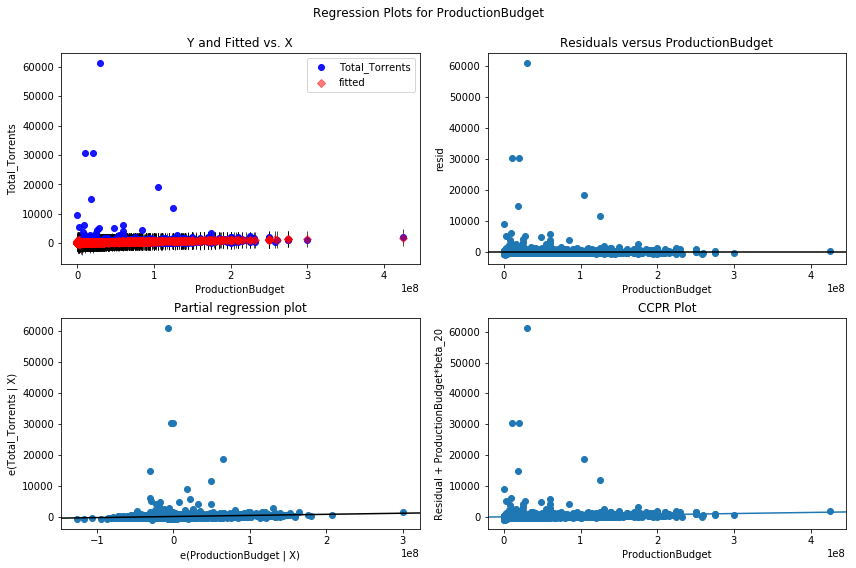

In [103]:
% matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results,'ProductionBudget', fig=fig)

---
# Log Transform

In [104]:
df.columns

Index(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director', 'Genre',
       'Language', 'Metascore', 'Production', 'Rated', 'Released', 'Runtime',
       'Title', 'Type', 'Writer', 'imdbID', 'imdbRating', 'imdbVotes',
       'Kat_Count', 'Pirate_Count', 'Extra_Count', 'Torrentz_Count',
       'Torrentz_Ver_Count', 'Zoogle_Ver_Count', 'ProductionBudget',
       'DomesticBudget', 'WorldGross', 'Total_Torrents', 'Year', 'Month',
       'Genre_Single'],
      dtype='object')

/Users/bryant/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning:

divide by zero encountered in log

/Users/bryant/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning:

'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.



ValueError: range parameter must be finite.

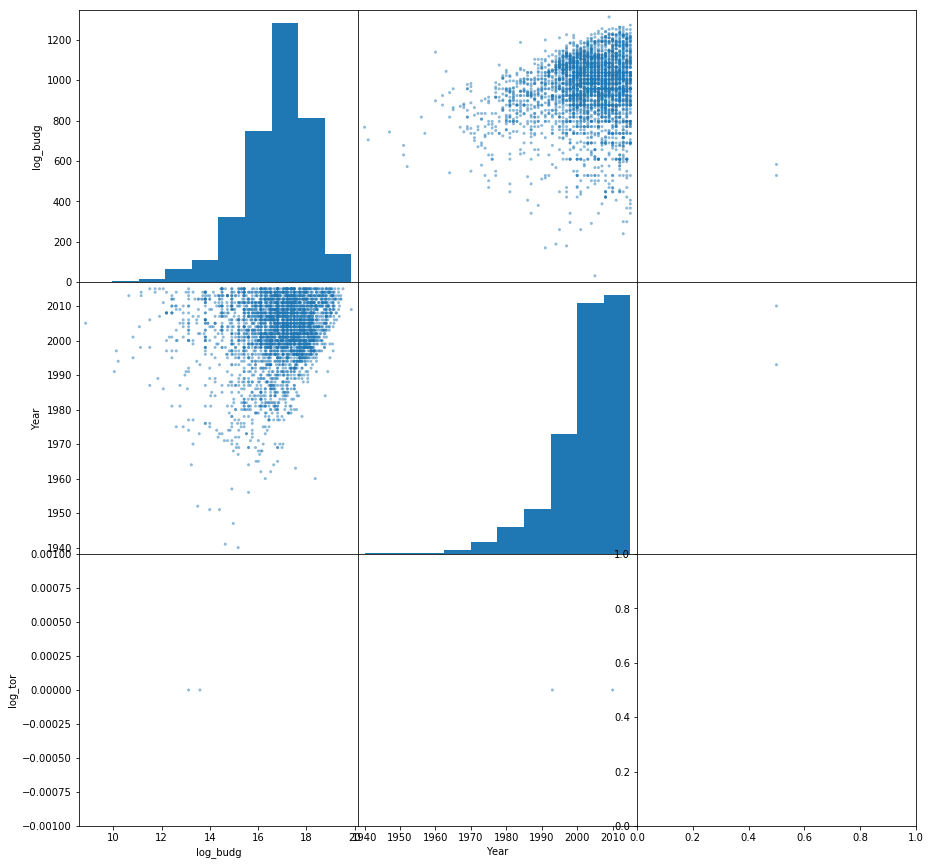

In [106]:
df['log_budg']=np.log(df['ProductionBudget'])
#df_sub['log_year']=np.log(df_sub.Year)
#df_sub['log_run']=np.log(df_sub.Runtime)
df['log_tor']=np.log(df['Total_Torrents'])

trans = df[['log_budg', 'Year', 'log_tor']]
plt.rcParams['figure.figsize'] = (15, 15)
pd.tools.plotting.scatter_matrix(trans)

In [108]:
log_patsy_formula = 'log_tor ~ log_budg + Year + Month'
y, x = dmatrices(log_patsy_formula, data=df, return_type='dataframe')

In [109]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF

df_a = df[['log_budg', 'Year', 'Month', 'log_tor']]
fig = FF.create_scatterplotmatrix(df_a, diag='histogram', index='Month',
                                  height=800, width=800)
py.iplot(fig, filename='Histograms along Diagonal Subplots')

/Users/bryant/anaconda/lib/python3.6/site-packages/plotly/tools.py:1422: UserWarning:

plotly.tools.FigureFactory.create_scatterplotmatrix is deprecated. Use plotly.figure_factory.create_scatterplotmatrix



In [110]:
import statsmodels.formula.api as smf
results = smf.ols(formula=log_patsy_formula, data=df,).fit()
results.summary()

/Users/bryant/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1366: RuntimeWarning:

invalid value encountered in subtract

/Users/bryant/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

/Users/bryant/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

/Users/bryant/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_tor   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 19 Sep 2017   Prob (F-statistic):                nan
Time:                        16:13:07   Log-Likelihood:                    nan
No. Observations:                3499   AIC:                               nan
Df Residuals:                    3495   BIC:                               nan
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept         nan        nan        nan        nan         nan         nan
log_budg          inf        nan        nan        nan         nan         nan
Year              nan        nan        nan        nan         nan         nan
Month             nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                     4.11e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y)

# store results
log_mod_lr_score = model.score(x,y)

In [ ]:
from sklearn import cross_validation as cv
from sklearn import metrics

x_train, x_test, y_train, y_test = cv.train_test_split(x,y,test_size=0.20,random_state=1234)

model = LinearRegression().fit(x_train, y_train)

# store results
log_mean_sq_err = metrics.mean_squared_error(y_train,model.predict(x_train))
log_cv_mod_score = model.score(x_train, y_train)

In [ ]:
# reset x, y otherwise errors occur
y, x = dmatrices(log_patsy_formula, data=df_sub, return_type='dataframe')

from sklearn.cross_validation import KFold
kf = KFold(len(df_sub), n_folds=10, shuffle=True)

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf2 = LinearRegression().fit(x.iloc[train_index], y.iloc[train_index])

# store results
log_mean_sq_errKf = metrics.mean_squared_error(y_train,model.predict(x_train))
log_cvKf_mod_score = clf2.score(x,y)

In [ ]:
#LOG RESULTS
print('Log Model Linear Regression Score = {0}'.format(log_mod_lr_score))
print('            Log Mean Square Error = {0}'.format(log_mean_sq_err))
print(' Log Cross Validation Model Score = {0}'.format(log_cv_mod_score))
print('     Log Mean Squred Error K-Fold = {0}'.format(log_mean_sq_errKf))
print('Log Cross Val. K-Fold Model Score = {0}'.format(log_cvKf_mod_score))

In [ ]:
df_TEST = pd.read_csv('data/test_data2.csv', encoding='latin-1')

df_TEST['log_budg']=np.log(df_TEST.Prod_Budget)
df_TEST['log_run']=np.log(df_TEST.Runtime)
df_TEST['log_tor']=np.log(df_TEST.Total_Torrents)

def split_to_array(ser):
    split_array = np.array(ser.strip().replace(',','').split(' '))
    return pd.Series(split_array)

genres = df_yr.Genre.apply(split_to_array)
genres = pd.Series(genres.values.ravel()).dropna()
genres = genres.value_counts().sort_values(ascending=False)

def convert_frequency(ser, genres=genres):
    split_array = np.array(ser.strip().replace(',','').split(' '))
    genre = genres.loc[split_array].argmax()
    return genre

df_TEST['Genre_Single'] = df_TEST.Genre.apply(convert_frequency)

log_patsy_formula_test = 'log_tor ~ log_budg + Year + Month + log_run + Genre_Single'
y, x = dmatrices(log_patsy_formula_test, data=df_TEST, return_type='dataframe')

print(clf2.score(x_test, y_test))
print(metrics.mean_squared_error(y_test,model.predict(x_test)))

In [ ]:
_ = plt.plot(y, model.predict(x), 'bo')

In [ ]:
plt.figure(figsize=(25,10))

ind = np.arange(len(yr_dict))
width = 0.35

bar_year = [year for year, count in yr_lst]
bar_count = [count for year, count in yr_lst]

plt.bar(ind, bar_count, width, color='r')

plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Number of Torrents per Year')
plt.xticks(ind + width/2., (bar_year), rotation='vertical')
plt.yticks(np.arange(0, 91, 5))

plt.show()

In [ ]:
#log_tor ~ log_budg + Year + Month + log_run + Genre_Single'

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results,'log_budg', fig=fig)

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results,'Year', fig=fig)

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results,'Month', fig=fig)